### CNN
* http://andrew.gibiansky.com/blog/machine-learning/convolutional-neural-networks/
* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721
* https://algotravelling.com/ru/%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5-%D1%8D%D1%82%D0%BE-%D0%B2%D0%B5%D1%81%D0%B5%D0%BB%D0%BE-3/
* https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/
* https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b
* https://github.com/udsclub/images-classification-caltech
* https://www.asozykin.ru/courses/nnpython

### Preprocessing
* https://www.embedded-vision.com/sites/default/files/apress/computervisionmetrics/chapter2/9781430259299_Ch02.pdf
* https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network
* https://www.quora.com/What-are-some-ways-of-pre-procesing-images-before-applying-convolutional-neural-networks-for-the-task-of-image-classification
* http://cs231n.github.io/neural-networks-2/#datapre
* http://www.robots.ox.ac.uk/~vgg/practicals/cnn/#getting-started
* https://www.safaribooksonline.com/library/view/programming-computer-vision/9781449341916/ch01.html
* https://stackoverflow.com/a/10169025/5151861
* augmentation tf+keras http://machinelearningmastery.com/image-augmentation-deep-learning-keras/

#### Augmentation
* rotation: random with angle between 0° and 360° (uniform)
* translation: random with shift between -10 and 10 pixels (uniform)
* rescaling: random with scale factor between 1/1.6 and 1.6 (log-uniform)
* flipping: yes or no (bernoulli)
* shearing: random with angle between -20° and 20° (uniform)
* stretching: random with stretch factor between 1/1.3 and 1.3 (log-uniform)
* https://www.tensorflow.org/api_docs/python/tf/image
* https://github.com/aleju/imgaug
* http://augmentor.readthedocs.io/en/master/
* https://github.com/analysiscenter/dataset

* uint8 0 to 255
* uint16 0 to 65535
* uint32 0 to 232
* float -1 to 1 or 0 to 1
* int8 -128 to 127
* int16 -32768 to 32767
* int32-231 to 231 - 1

* Gaussian blurring of images
* Morphology—Counting Objects

Ресайзинг - важно
* http://ufldl.stanford.edu/wiki/index.php/UFLDL_Tutorial

* одну- дву- слойную cnn
* графики ошибки
* 224х224
* 32х32
* в керас
* серые картинки 
* тензор борд
* презентация по аугментации

whitening

In [407]:
from scipy import ndimage
import numpy as np
import pandas as pd
import os
from IPython.display import display, Image
from scipy import misc
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow
from sklearn.model_selection import train_test_split

%matplotlib inline

In [408]:
pixel_depth = 255.0 # number of levels per pixel
num_classes = 257 # number of total classes
test_folder = 'data/test' # dir, where test set is placed
train_folder = 'data/train' # dir, where train set is placed

In [409]:
def reshape(img):
    nsamples, nx, ny = img.shape
    return img.reshape((nsamples,nx*ny))

In [ ]:
def load_test_set():
    num_images = 0
    images = os.listdir(test_folder)
    test_set = []
    for image in images:
        image = os.path.join(test_folder, image)
        test_set.append(io.imread(image))
    return test_set

In [ ]:
test_set = load_test_set()

In [584]:
# data folder paths
dir_train = os.path.join('data', 'train')
dir_test = os.path.join('data', 'test')

# collect train metadata
train_metadata = []

for root, subFolders, files in os.walk(dir_train):
    for sf in subFolders:
        print('reading files from {}...'.format(sf))
        for f_name in os.listdir(os.path.join(dir_train, sf)):
            if not f_name.startswith('.'):
                temp = misc.imread(os.path.join(dir_train, sf, f_name)) # read image
                # collect image metadata
                image_metadata = []
                image_metadata.extend([sf, f_name])
                image_metadata.extend( list(temp.shape) if len(temp.shape) == 3\
                                      else [temp.shape[0], temp.shape[1], 1])
                image_metadata.extend([temp.nbytes, temp.dtype])
                # append image metadata to list
                train_metadata.append(image_metadata)

reading files from 001.ak47...
reading files from 002.american-flag...
reading files from 003.backpack...
reading files from 004.baseball-bat...
reading files from 005.baseball-glove...
reading files from 006.basketball-hoop...
reading files from 007.bat...
reading files from 008.bathtub...
reading files from 009.bear...
reading files from 010.beer-mug...
reading files from 011.billiards...
reading files from 012.binoculars...
reading files from 013.birdbath...
reading files from 014.blimp...
reading files from 015.bonsai-101...
reading files from 016.boom-box...
reading files from 017.bowling-ball...
reading files from 018.bowling-pin...
reading files from 019.boxing-glove...
reading files from 020.brain-101...
reading files from 021.breadmaker...
reading files from 022.buddha-101...
reading files from 023.bulldozer...
reading files from 024.butterfly...
reading files from 025.cactus...
reading files from 026.cake...
reading files from 027.calculator...
reading files from 028.camel...

reading files from 228.triceratops...
reading files from 229.tricycle...
reading files from 230.trilobite-101...
reading files from 231.tripod...
reading files from 232.t-shirt...
reading files from 233.tuning-fork...
reading files from 234.tweezer...
reading files from 235.umbrella-101...
reading files from 236.unicorn...
reading files from 237.vcr...
reading files from 238.video-projector...
reading files from 239.washing-machine...
reading files from 240.watch-101...
reading files from 241.waterfall...
reading files from 242.watermelon...
reading files from 243.welding-mask...
reading files from 244.wheelbarrow...
reading files from 245.windmill...
reading files from 246.wine-bottle...
reading files from 247.xylophone...
reading files from 248.yarmulke...
reading files from 249.yo-yo...
reading files from 250.zebra...
reading files from 251.airplanes-101...
reading files from 252.car-side-101...
reading files from 253.faces-easy-101...
reading files from 254.greyhound...
reading fil

In [597]:
len(train_metadata)

22897

In [601]:
%%time
dir_train = 'data/train'
train_df = pd.DataFrame(columns = ['category', 'image_name', 'width', 'height', 'type', 'target'])
folders = os.listdir(dir_train)
for ind, folder in enumerate(folders):
    if ind % 30 == 0:
        print('{}'.format(folder))
    folder = os.path.join(train_folder, folder)
    if os.path.isdir(folder):
        image_files = os.listdir(folder)
        for image_file in image_files:
            if not image_file.startswith('.'):
                image = misc.imread(os.path.join(folder, image_file))
                category = folder[15:]
                width = image.shape[0]
                height = image.shape[1]
                #target = folder.split('.')[0].split('/')[2]
                target = int(folder.split('.')[0].split('/')[2])
                train_df.loc[train_df.shape[0]]=[category, image_file, width, 
                                                 height, image.dtype, target]

.DS_Store
030.canoe
060.duck
090.gorilla
120.joy-stick
150.octopus
180.screwdriver
210.syringe
240.watch-101
CPU times: user 5min 54s, sys: 28.4 s, total: 6min 23s
Wall time: 6min 54s


In [603]:
train_df.to_csv('data/train_df.csv')

### Classes distribution

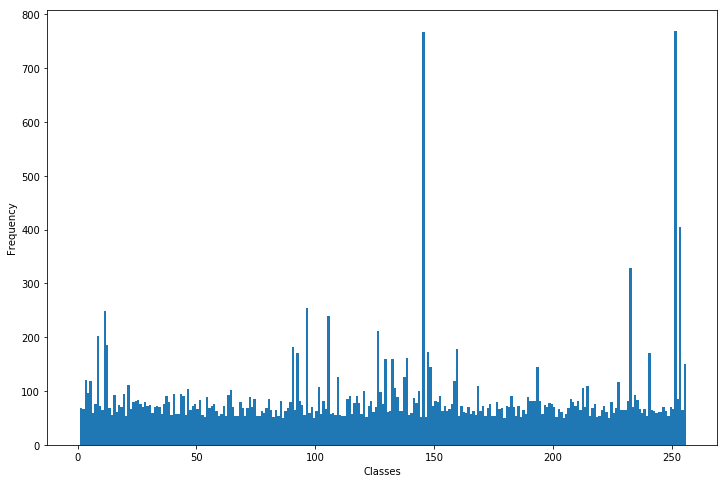

In [604]:
plt.figure(figsize=(12, 8))
plt.hist(train_df['target'], bins=range(len(train_df['target'].unique())))
plt.xlabel('Classes')
plt.ylabel('Frequency');

In [607]:
df = pd.read_csv('data/train_df.csv', index_col=0)

In [609]:
y = df['target']
X = df.copy()
X.drop('target', axis=1, inplace=True)
df.to_csv('train_data')

In [281]:
X.to_csv('data/train_features')
y.to_csv('data/train_target')

In [612]:
def check_dir(directory):
    if not os.path.exists(directory):
        create_dir(directory)

In [613]:
def create_dir(directory):
    os.makedirs(directory)

In [614]:
def norm(img):
    return img / 255.0

In [615]:
dir_train_transformed = 'data/train_transformed'
def transform_train_set(img_size=(32, 32)):
    check_dir(transform_folder)
    folders = os.listdir(train_folder)
    for ind, folder in enumerate(folders):
            subfolder = os.path.join(train_folder, folder)
            if os.path.isdir(subfolder):
                if ind % 30 == 0:
                    print('{}'.format(folder))
                for image_file in os.listdir(subfolder):
                    if not image_file.startswith('.'):
                        name = os.path.join(subfolder, image_file)
                        image = misc.imread(name)
                        if len(image.shape) == 2:
                            image = np.stack((image,)*3)
                        image = misc.imresize(image, img_size, interp='bicubic')
                        #image = norm(image)
                        fold_to_save = os.path.join(transform_folder, image_file)
                        misc.imsave(fold_to_save, image)

In [616]:
%%time
img_size = (64,64)
transform_train_set(img_size)

030.canoe
060.duck
090.gorilla
120.joy-stick
150.octopus
180.screwdriver
210.syringe
240.watch-101
CPU times: user 3min 47s, sys: 21.4 s, total: 4min 8s
Wall time: 4min 28s


In [624]:
%%time
# load data in flattened form

# img parameters
img_shape = (64, 64)
channels = 3
img_shape_flattened = img_shape[0] * img_shape[1] * channels
img_qty = len(train_metadata)

# initialize X,y
X = np.empty(shape=(img_qty, img_shape_flattened), dtype=np.int8)
y = np.empty(shape=(img_qty,), dtype=np.uint16)

# read images
for i,f_name in enumerate(os.listdir(dir_train_transformed)):
    if i % 5000 == 0:
        print('{:6d}/{:6d} images loaded'.format(i, img_qty))
    
    img_path = os.path.join(dir_train_transformed, f_name)
    X[i, :] = misc.imread(img_path).flatten('C') # since img is np.ndarray, flatten in row-style
    y[i] = train_df.loc[train_df['image_name'] == f_name, 'target'].iloc[0]

     0/ 22897 images loaded
  5000/ 22897 images loaded
 10000/ 22897 images loaded
 15000/ 22897 images loaded
 20000/ 22897 images loaded
CPU times: user 1min 16s, sys: 3.41 s, total: 1min 19s
Wall time: 1min 22s


In [628]:
X_train, X_test, y_train, t_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [629]:
from sklearn.linear_model import LogisticRegression  # baseline classifier
from sklearn.decomposition import PCA # to reduce training columns
from sklearn.pipeline import Pipeline # to "glue" model steps/components together
from sklearn.metrics import accuracy_score # to test quality of the classifier

In [515]:
pca = PCA(n_components=50, random_state=42)
svc = LogisticRegression(random_state=42, C=0.1, max_iter=50, verbose=2, n_jobs=-1, class_weight='balanced')

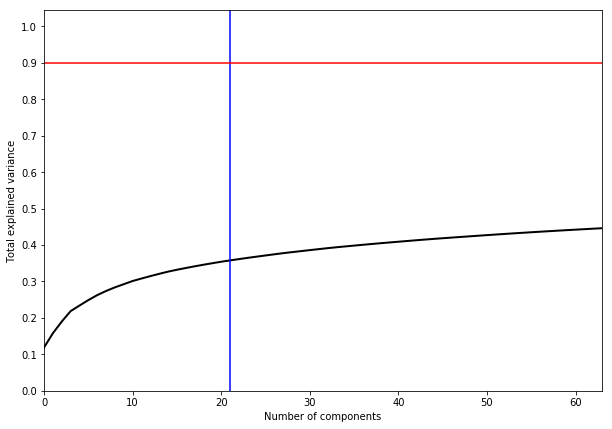

In [630]:
pca = PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();